In [1]:
import  jpholiday
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
from sklearn.model_selection import train_test_split

In [3]:
# 気温情報の表示

years = ['R1', 'R2', 'R3', 'R4']
df_t = pd.DataFrame()
for year in years:
    d_t = pd.read_csv(f'{year}_temp.csv', encoding='shift-jis', skiprows=1)
    df_t = pd.concat([df_t, d_t], axis=0)

# 気温情報の整理
df_t = df_t[~(df_t['Unnamed: 0']=='年月日時') & ~(df_t['東京.1']=='品質情報')]
df_t = df_t.drop(columns=['東京.1', '東京.2'])
df_t.columns=['年月日時', '気温(℃)']
df_t = df_t.reset_index(drop=True)

In [4]:
# 日照量の表示
years = ['R1', 'R2', 'R3', 'R4']

df_s = pd.DataFrame()
for year in years:
    d_s = pd.read_csv(f'{year}_sun.csv', encoding='cp932', skiprows=1)
    df_s = pd.concat([df_s, d_s], axis=0)

# 日照量の整理
df_s = df_s[~(df_s['Unnamed: 0']=='年月日時') & ~(df_s['東京.1']=='品質情報')]
df_s = df_s.drop(columns=['東京.1', '東京.2'])
df_s.columns=['年月日時', '日射量(MJ/㎡)']
df_s = df_s.reset_index(drop=True)

In [5]:
# 天気の表示
years = ['R1', 'R2', 'R3', 'R4']

df_w = pd.DataFrame()
for year in years:
    d_w = pd.read_csv(f'{year}_wet.csv', encoding='shift-jis', skiprows=1)
    df_w = pd.concat([df_w, d_w], axis=0)

# 日照時間の整理
df_w = df_w[~(df_w['Unnamed: 0']=='年月日時') & ~(df_w['東京.1']=='品質情報')] # 年月日　と　品質情報 を含む行いが意を抽出
df_w = df_w.drop(columns=['東京.1', '東京.2']) # 左記の２つを列から削除
df_w.columns=['年月日時', '天気'] # カラム名を左記の２つに変更
df_w = df_w.reset_index(drop=True)
df_w = df_w.fillna(0)

In [6]:
# 気温、日照時間、天気の表を年月日時の項目を基準として merge

df = pd.merge(df_t, df_s, on='年月日時') # 天気と気温の merge
df = pd.merge(df, df_w, on='年月日時') # 上で merge した df と天気を merge
df['年月日時'] = pd.to_datetime(df['年月日時'], format='%Y-%m-%d %H:%M')


# indexを　年月日時 に変更
df = df.reset_index(drop=True)
df = df.reindex(columns=['年月日時', '気温(℃)', '天気', '日射量(MJ/㎡)'])
df

,年月日時,気温(℃),天気,日射量(MJ/㎡)
0,2019-04-01 01:00:00,8.2,0,0
1,2019-04-01 02:00:00,7.8,0,0
2,2019-04-01 03:00:00,7.3,1,0
3,2019-04-01 04:00:00,7.1,0,0
4,2019-04-01 05:00:00,6.7,0,0.00
...,...,...,...,...
35059,2023-03-31 20:00:00,15.1,0,0
35060,2023-03-31 21:00:00,14.3,1,0
35061,2023-03-31 22:00:00,13.6,0,0
35062,2023-03-31 23:00:00,13.1,0,0


In [7]:
# 電力需要実績
years = [2019, 2020, 2021, 2022, 2023]

df_e = pd.DataFrame()
for year in years:
    _df = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-{year}.csv', encoding='shift-jis', skiprows=1)
    df_e = pd.concat([df_e, _df], axis=0)
    df_e = df_e.reset_index(drop=True)

In [8]:
# 日時データを気象要素と統一する
datetimes = []

for i, val in df_e.iterrows():
    date = val['DATE']
    time = val['TIME']
    str_datetime = f'{date} {time}'
    datetime = dt.strptime(str_datetime, '%Y/%m/%d %H:%M')
    datetimes.append(datetime)
df_e['年月日時'] = datetimes
df_e['年月日時'] = pd.to_datetime(df_e['年月日時'], format='%Y-%m-%d %H:%M')


# DATE と　TIME 列を drop　し日時情報を　年月日時　のみにする
df_e.drop(columns=['DATE', 'TIME'], inplace=True)


# 気象データにない日時データを削除し、年月日時をindexに変更する

df_e = df_e.loc[~((df_e['年月日時'] >= '2019-01-01 00:00:00') & (df_e['年月日時'] <='2019-04-01 00:00:00'))]
df_e = df_e.loc[~(df_e['年月日時'] >= '2023-04-01 01:00:00')]
df_e = df_e.reset_index(drop=True)
df_e = df_e.reindex(columns=['年月日時', '実績(万kW)'])
df_e

,年月日時,実績(万kW)
0,2019-04-01 01:00:00,2493
1,2019-04-01 02:00:00,2480
2,2019-04-01 03:00:00,2493
3,2019-04-01 04:00:00,2547
4,2019-04-01 05:00:00,2712
...,...,...
35059,2023-03-31 20:00:00,2898
35060,2023-03-31 21:00:00,2759
35061,2023-03-31 22:00:00,2639
35062,2023-03-31 23:00:00,2510


In [9]:
# 気象データと電力需要データを「年月日時」を基準に結合する
df = pd.merge(df, df_e, on='年月日時') 
df = df.reindex(columns=['年月日時', '実績(万kW)', '気温(℃)', '天気', '日射量(MJ/㎡)'])
df

,年月日時,実績(万kW),気温(℃),天気,日射量(MJ/㎡)
0,2019-04-01 01:00:00,2493,8.2,0,0
1,2019-04-01 02:00:00,2480,7.8,0,0
2,2019-04-01 03:00:00,2493,7.3,1,0
3,2019-04-01 04:00:00,2547,7.1,0,0
4,2019-04-01 05:00:00,2712,6.7,0,0.00
...,...,...,...,...,...
35059,2023-03-31 20:00:00,2898,15.1,0,0
35060,2023-03-31 21:00:00,2759,14.3,1,0
35061,2023-03-31 22:00:00,2639,13.6,0,0
35062,2023-03-31 23:00:00,2510,13.1,0,0


In [10]:
#　休日情報を追加する（平日を０、休・祝日を１）
df['休・祝日'] = df['年月日時'].apply(lambda x: 1 if jpholiday.is_holiday(x) or x.weekday() >= 5 else 0)
df

,年月日時,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
0,2019-04-01 01:00:00,2493,8.2,0,0,0
1,2019-04-01 02:00:00,2480,7.8,0,0,0
2,2019-04-01 03:00:00,2493,7.3,1,0,0
3,2019-04-01 04:00:00,2547,7.1,0,0,0
4,2019-04-01 05:00:00,2712,6.7,0,0.00,0
...,...,...,...,...,...,...
35059,2023-03-31 20:00:00,2898,15.1,0,0,0
35060,2023-03-31 21:00:00,2759,14.3,1,0,0
35061,2023-03-31 22:00:00,2639,13.6,0,0,0
35062,2023-03-31 23:00:00,2510,13.1,0,0,0


In [11]:
# 統計量を出せるようにデータ型を変更する
df['気温(℃)'] = pd.to_numeric(df['気温(℃)'], errors='coerce')
df['天気'] = pd.to_numeric(df['天気'], errors='coerce')
df['日射量(MJ/㎡)'] = pd.to_numeric(df['日射量(MJ/㎡)'] , errors='coerce')
print(df['気温(℃)'].dtype)

float64


In [12]:
df.describe()

,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
count,35064.000000,35059.000000,35064.000000,35059.000000,35064.000000
mean,3200.686773,16.693551,1.087155,0.552449,0.327886
std,669.601077,8.090066,2.300523,0.860256,0.469450
min,1877.000000,-3.200000,0.000000,0.000000,0.000000
25%,2677.000000,9.900000,0.000000,0.000000,0.000000
50%,3133.000000,16.700000,0.000000,0.020000,0.000000
75%,3606.000000,23.300000,1.000000,0.850000,1.000000
max,5930.000000,36.600000,15.000000,3.660000,1.000000


In [13]:
df[df['日射量(MJ/㎡)'].isna()]

,年月日時,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
1018,2019-05-13 11:00:00,3314,19.0,0,NaN,0
5916,2019-12-03 13:00:00,3514,NaN,0,NaN,0
5917,2019-12-03 14:00:00,3533,NaN,0,NaN,0
6057,2019-12-09 10:00:00,4374,NaN,0,NaN,0
6062,2019-12-09 15:00:00,4265,7.9,4,NaN,0


In [14]:
df[df['気温(℃)'].isna()]

,年月日時,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
5916,2019-12-03 13:00:00,3514,NaN,0,NaN,0
5917,2019-12-03 14:00:00,3533,NaN,0,NaN,0
6057,2019-12-09 10:00:00,4374,NaN,0,NaN,0
19316,2020-11-06 11:00:00,3426,NaN,0,0.49,0
19317,2020-11-06 11:00:00,3426,NaN,0,0.49,0


In [15]:
# Nan が入っている行を削除する
df = df.dropna(subset=['気温(℃)', '日射量(MJ/㎡)'])
df.describe()

,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
count,35057.000000,35057.000000,35057.000000,35057.000000,35057.000000
mean,3200.588442,16.693736,1.087258,0.552452,0.327952
std,669.607591,8.090151,2.300656,0.860280,0.469474
min,1877.000000,-3.200000,0.000000,0.000000,0.000000
25%,2677.000000,9.900000,0.000000,0.000000,0.000000
50%,3133.000000,16.700000,0.000000,0.020000,0.000000
75%,3606.000000,23.300000,1.000000,0.850000,1.000000
max,5930.000000,36.600000,15.000000,3.660000,1.000000


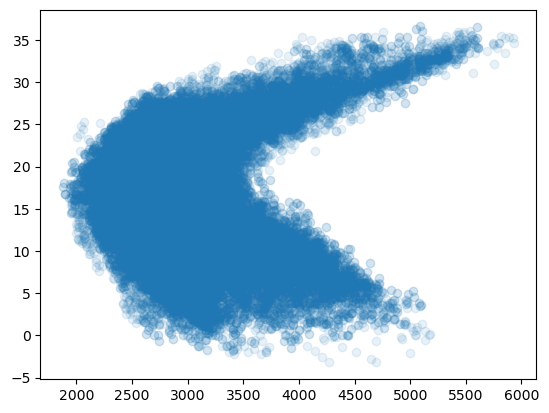

In [16]:
plt.scatter(x=df['実績(万kW)'], y=df['気温(℃)'], alpha=0.1)

In [17]:
df_mean = df.groupby(pd.Grouper(key='年月日時', freq='M')).mean()

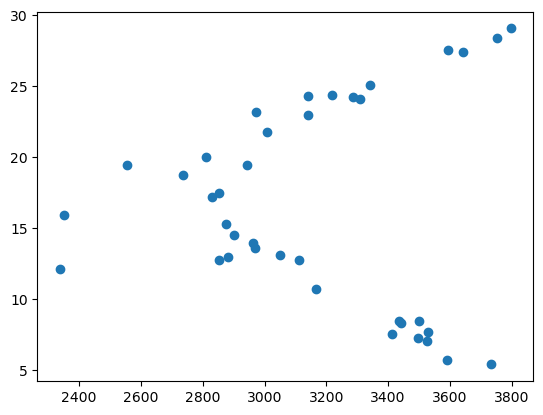

In [18]:
plt.scatter(x=df_mean['実績(万kW)'], y=df_mean['気温(℃)'])

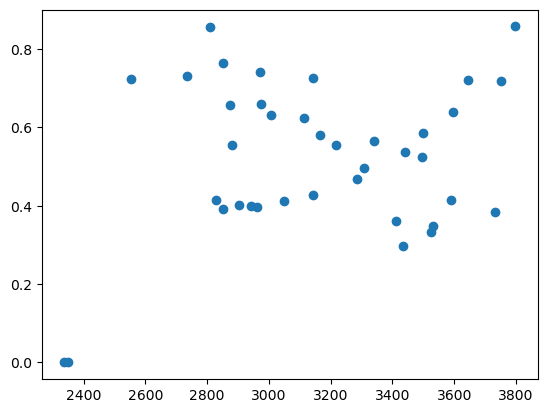

In [19]:
plt.scatter(x=df_mean['実績(万kW)'], y=df_mean['日射量(MJ/㎡)'])

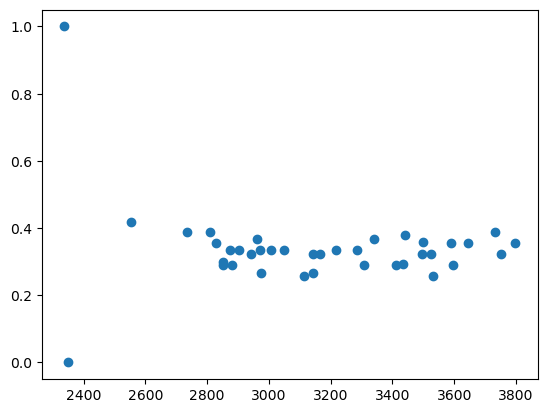

In [20]:
plt.scatter(x=df_mean['実績(万kW)'], y=df_mean['休・祝日'])

In [21]:
df.describe()

,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
count,35057.000000,35057.000000,35057.000000,35057.000000,35057.000000
mean,3200.588442,16.693736,1.087258,0.552452,0.327952
std,669.607591,8.090151,2.300656,0.860280,0.469474
min,1877.000000,-3.200000,0.000000,0.000000,0.000000
25%,2677.000000,9.900000,0.000000,0.000000,0.000000
50%,3133.000000,16.700000,0.000000,0.020000,0.000000
75%,3606.000000,23.300000,1.000000,0.850000,1.000000
max,5930.000000,36.600000,15.000000,3.660000,1.000000


### 機械学習の実行

#### Prophet

In [12]:
from prophet import Prophet

In [23]:
# df['夏・冬日'] = df['気温(℃)'].apply(lambda x: 1 if (x >= 30 or x <= 5) else 0)

In [13]:
df_p = df

In [17]:
df_p = df_p.rename(columns={'年月日時': 'ds', '実績(万kW)': 'y', '気温': 'g', '休・祝日': 'h'})

df_p['DATE'] = df_p['ds']
df_p

df_p['DATE'] = df_p['DATE'].astype(str)
df_p

,ds,DATE,TIME,y,天気,日射量(MJ/㎡),h
0,2019-04-01 01:00:00,2019-04-01 01:00:00,01:00,2493,0,0.0,NaN
1,2019-04-01 02:00:00,2019-04-01 02:00:00,02:00,2480,0,0.0,NaN
2,2019-04-01 03:00:00,2019-04-01 03:00:00,03:00,2493,1,0.0,NaN
3,2019-04-01 04:00:00,2019-04-01 04:00:00,04:00,2547,0,0.0,NaN
4,2019-04-01 05:00:00,2019-04-01 05:00:00,05:00,2712,0,0.0,NaN
...,...,...,...,...,...,...,...
35059,2023-03-31 20:00:00,2023-03-31 20:00:00,20:00,2898,0,0.0,NaN
35060,2023-03-31 21:00:00,2023-03-31 21:00:00,21:00,2759,1,0.0,NaN
35061,2023-03-31 22:00:00,2023-03-31 22:00:00,22:00,2639,0,0.0,NaN
35062,2023-03-31 23:00:00,2023-03-31 23:00:00,23:00,2510,0,0.0,NaN


In [18]:
TIME = []
DATE = []
for index, datum in df_p.iterrows():
    date = datum['DATE'][:10]
    time = datum['DATE'][11:16]
    DATE.append(date)
    TIME.append(time)

df_p['DATE'] = DATE
df_p['TIME'] = TIME
df_p = df_p.reindex(columns=['ds', 'DATE', 'TIME', 'y', '天気', '日射量(MJ/㎡)', '休・祝日'])
df_p

,ds,DATE,TIME,y,天気,日射量(MJ/㎡),休・祝日
0,2019-04-01 01:00:00,2019-04-01,01:00,2493,0,0.0,NaN
1,2019-04-01 02:00:00,2019-04-01,02:00,2480,0,0.0,NaN
2,2019-04-01 03:00:00,2019-04-01,03:00,2493,1,0.0,NaN
3,2019-04-01 04:00:00,2019-04-01,04:00,2547,0,0.0,NaN
4,2019-04-01 05:00:00,2019-04-01,05:00,2712,0,0.0,NaN
...,...,...,...,...,...,...,...
35059,2023-03-31 20:00:00,2023-03-31,20:00,2898,0,0.0,NaN
35060,2023-03-31 21:00:00,2023-03-31,21:00,2759,1,0.0,NaN
35061,2023-03-31 22:00:00,2023-03-31,22:00,2639,0,0.0,NaN
35062,2023-03-31 23:00:00,2023-03-31,23:00,2510,0,0.0,NaN


In [19]:
model = Prophet().fit(df_p)

20:22:45 - cmdstanpy - INFO - Chain [1] start processing
20:22:55 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
future = model.make_future_dataframe(24*365, freq='H')
future

,ds
0,2019-04-01 01:00:00
1,2019-04-01 02:00:00
2,2019-04-01 03:00:00
3,2019-04-01 04:00:00
4,2019-04-01 05:00:00
...,...
43819,2024-03-30 20:00:00
43820,2024-03-30 21:00:00
43821,2024-03-30 22:00:00
43822,2024-03-30 23:00:00


In [23]:
pred = model.predict(future)
pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-04-01 01:00:00,3448.674520,1971.229429,2811.898133,3448.674520,3448.674520,-1050.644238,-1050.644238,-1050.644238,-626.308316,...,-149.777925,-149.777925,-149.777925,-274.557996,-274.557996,-274.557996,0.0,0.0,0.0,2398.030282
1,2019-04-01 02:00:00,3448.511187,1925.078344,2762.879807,3448.511187,3448.511187,-1091.261806,-1091.261806,-1091.261806,-686.941947,...,-130.036817,-130.036817,-130.036817,-274.283042,-274.283042,-274.283042,0.0,0.0,0.0,2357.249380
2,2019-04-01 03:00:00,3448.347854,1954.015688,2727.074805,3448.347854,3448.347854,-1091.849922,-1091.849922,-1091.849922,-707.500219,...,-110.341012,-110.341012,-110.341012,-274.008692,-274.008692,-274.008692,0.0,0.0,0.0,2356.497931
3,2019-04-01 04:00:00,3448.184520,2024.648663,2798.050773,3448.184520,3448.184520,-1047.360655,-1047.360655,-1047.360655,-682.823003,...,-90.802677,-90.802677,-90.802677,-273.734976,-273.734976,-273.734976,0.0,0.0,0.0,2400.823865
4,2019-04-01 05:00:00,3448.021187,2100.412590,2906.203247,3448.021187,3448.021187,-931.865348,-931.865348,-931.865348,-586.873552,...,-71.529869,-71.529869,-71.529869,-273.461926,-273.461926,-273.461926,0.0,0.0,0.0,2516.155840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,2024-03-30 20:00:00,2808.521349,-67.356175,5108.545186,240.034829,5454.837687,-350.945816,-350.945816,-350.945816,243.063335,...,-316.396039,-316.396039,-316.396039,-277.613112,-277.613112,-277.613112,0.0,0.0,0.0,2457.575534
43820,2024-03-30 21:00:00,2808.492024,-313.439125,4986.816362,239.854282,5455.166108,-531.727512,-531.727512,-531.727512,75.005418,...,-329.399289,-329.399289,-329.399289,-277.333641,-277.333641,-277.333641,0.0,0.0,0.0,2276.764512
43821,2024-03-30 22:00:00,2808.462698,-487.467029,4784.645768,239.673735,5455.494529,-750.697998,-750.697998,-750.697998,-132.356413,...,-341.287164,-341.287164,-341.287164,-277.054421,-277.054421,-277.054421,0.0,0.0,0.0,2057.764700
43822,2024-03-30 23:00:00,2808.433373,-805.464571,4503.780208,239.493188,5455.822950,-970.559932,-970.559932,-970.559932,-341.812263,...,-351.972186,-351.972186,-351.972186,-276.775483,-276.775483,-276.775483,0.0,0.0,0.0,1837.873441


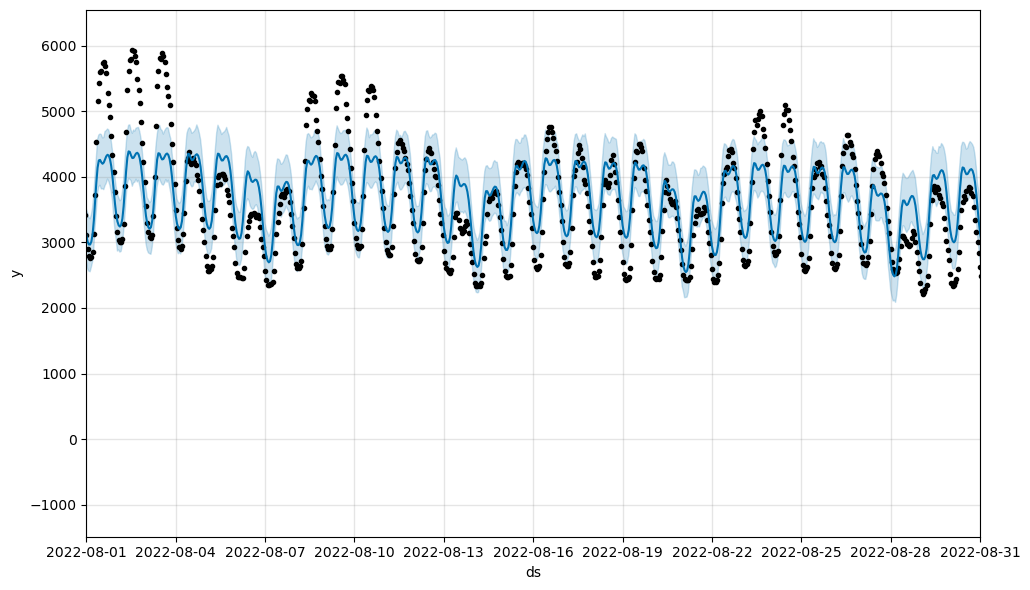

In [25]:
model.plot(pred)
plt.xlim(dt(2022, 8, 1), dt(2022, 8, 31))
plt.show()

In [26]:
df_2020 = pd.read_csv(f'https://www.tepco.co.jp/forecast/html/images/juyo-2021.csv', encoding='shift-jis', skiprows=1)
df_2020

,DATE,TIME,実績(万kW)
0,2021/1/1,0:00,3184
1,2021/1/1,1:00,2978
2,2021/1/1,2:00,2834
3,2021/1/1,3:00,2743
4,2021/1/1,4:00,2697
...,...,...,...
8755,2021/12/31,19:00,3888
8756,2021/12/31,20:00,3823
8757,2021/12/31,21:00,3717
8758,2021/12/31,22:00,3589


In [28]:
pred_2020 = pred[(pred['ds'] >= dt(2021, 1, 1)) & (pred['ds'] < dt(2022, 1, 1))].reset_index(drop=True)
pred_2020

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-01 00:00:00,3230.096178,2640.657943,3437.620106,3230.096178,3230.096178,-182.251899,-182.251899,-182.251899,-513.138614,...,118.514995,118.514995,118.514995,212.371720,212.371720,212.371720,0.0,0.0,0.0,3047.844279
1,2021-01-01 01:00:00,3230.097807,2534.692846,3336.379002,3230.097807,3230.097807,-294.476266,-294.476266,-294.476266,-626.308316,...,119.415825,119.415825,119.415825,212.416225,212.416225,212.416225,0.0,0.0,0.0,2935.621541
2,2021-01-01 02:00:00,3230.099436,2496.515747,3322.489957,3230.099436,3230.099436,-354.242349,-354.242349,-354.242349,-686.941947,...,120.233912,120.233912,120.233912,212.465685,212.465685,212.465685,0.0,0.0,0.0,2875.857086
3,2021-01-01 03:00:00,3230.101065,2459.396053,3221.963089,3230.101065,3230.101065,-374.057213,-374.057213,-374.057213,-707.500219,...,120.922894,120.922894,120.922894,212.520112,212.520112,212.520112,0.0,0.0,0.0,2856.043852
4,2021-01-01 04:00:00,3230.102694,2492.031479,3262.604035,3230.102694,3230.102694,-348.810250,-348.810250,-348.810250,-682.823003,...,121.433235,121.433235,121.433235,212.579518,212.579518,212.579518,0.0,0.0,0.0,2881.292443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2021-12-31 19:00:00,3345.316049,3574.022594,4382.413684,3345.316049,3345.316049,639.381688,639.381688,639.381688,355.968239,...,71.208030,71.208030,71.208030,212.205419,212.205419,212.205419,0.0,0.0,0.0,3984.697737
8756,2021-12-31 20:00:00,3345.416428,3479.877797,4251.724281,3345.416428,3345.416428,517.183218,517.183218,517.183218,243.063335,...,61.923585,61.923585,61.923585,212.196299,212.196299,212.196299,0.0,0.0,0.0,3862.599647
8757,2021-12-31 21:00:00,3345.516807,3300.133774,4081.576003,3345.516807,3345.516807,338.946720,338.946720,338.946720,75.005418,...,51.749318,51.749318,51.749318,212.191984,212.191984,212.191984,0.0,0.0,0.0,3684.463527
8758,2021-12-31 22:00:00,3345.617186,3057.265603,3867.793332,3345.617186,3345.617186,120.525546,120.525546,120.525546,-132.356413,...,40.689470,40.689470,40.689470,212.192489,212.192489,212.192489,0.0,0.0,0.0,3466.142732


In [29]:
df_2020 = df_2020.rename(columns={'実績(万kW)':'y'})

In [30]:
df_2020

,DATE,TIME,y
0,2021/1/1,0:00,3184
1,2021/1/1,1:00,2978
2,2021/1/1,2:00,2834
3,2021/1/1,3:00,2743
4,2021/1/1,4:00,2697
...,...,...,...
8755,2021/12/31,19:00,3888
8756,2021/12/31,20:00,3823
8757,2021/12/31,21:00,3717
8758,2021/12/31,22:00,3589


In [31]:
results = pd.DataFrame()

In [32]:
# 実測値
results['t'] = df_2020['y']

# 予測値
results['y'] = pred_2020['yhat']
results['diff'] = results['t'] - results['y']

results

,t,y,diff
0,3184,3047.844279,136.155721
1,2978,2935.621541,42.378459
2,2834,2875.857086,-41.857086
3,2743,2856.043852,-113.043852
4,2697,2881.292443,-184.292443
...,...,...,...
8755,3888,3984.697737,-96.697737
8756,3823,3862.599647,-39.599647
8757,3717,3684.463527,32.536473
8758,3589,3466.142732,122.857268


In [33]:
results.describe()

,t,y,diff
count,8760.000000,8760.000000,8760.000000
mean,3197.432877,3201.059035,-3.626158
std,661.344356,592.029397,313.655297
min,1955.000000,1426.935318,-1193.262730
25%,2678.000000,2794.529716,-179.822180
50%,3129.000000,3239.965121,-15.921835
75%,3601.000000,3635.844615,149.043431
max,5665.000000,4486.489243,1747.039582


In [34]:
np.mean(abs((results['y'] - results['t']) / results['t'])*100)

7.056546715220248

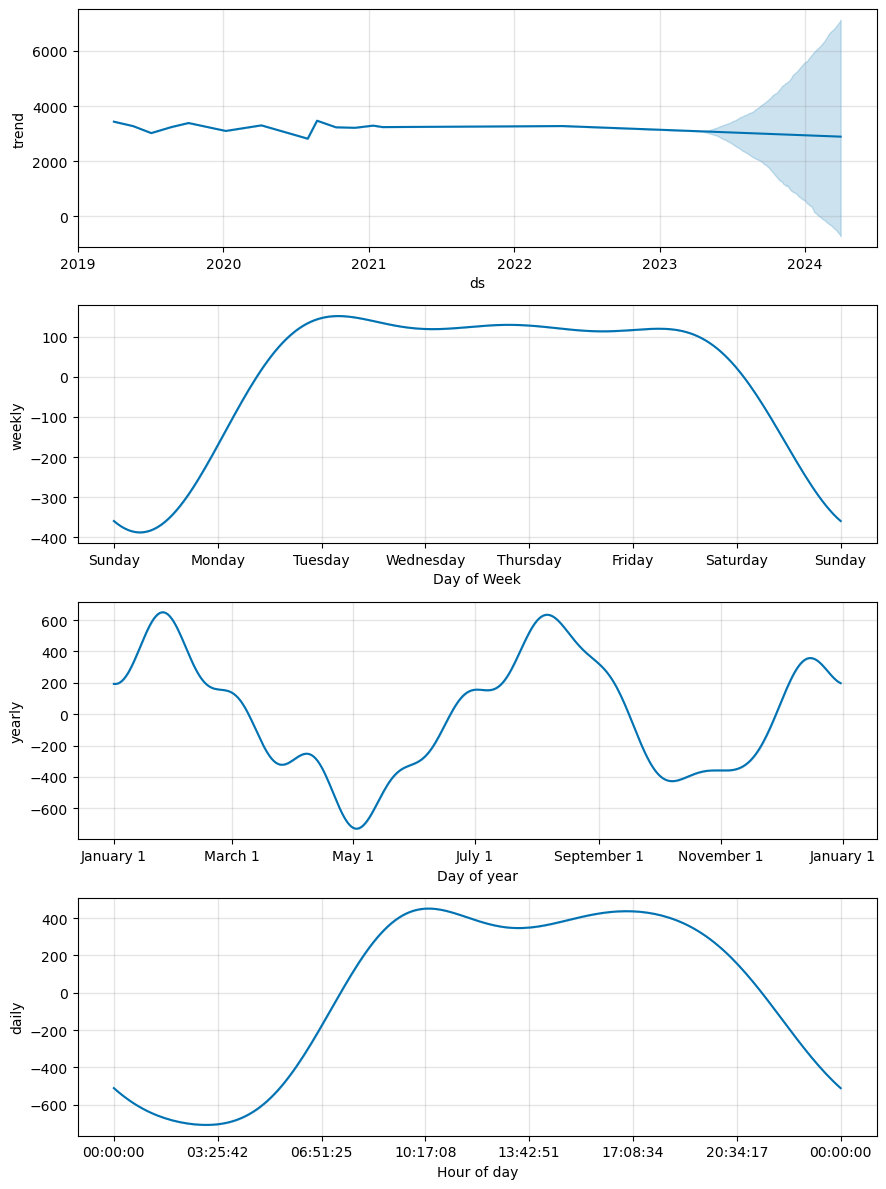

In [39]:
# 周期性の確認
model.plot_components(pred)
plt.show()

In [40]:
df_up_4500 = df[df['実績(万kW)'] >= 4500]
df_up_4500

,年月日時,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
2629,2019-07-19 14:00:00,4519,30.3,0,2.27,0
2748,2019-07-24 13:00:00,4515,30.5,0,3.31,0
2749,2019-07-24 14:00:00,4525,30.9,0,3.18,0
2750,2019-07-24 15:00:00,4508,31.0,2,2.02,0
2769,2019-07-25 10:00:00,4571,28.6,0,0.92,0
...,...,...,...,...,...,...
33882,2023-02-10 19:00:00,4651,2.0,0,0.00,0
33992,2023-02-15 09:00:00,4616,3.0,4,0.86,0
33993,2023-02-15 10:00:00,4515,4.5,0,0.97,0
34001,2023-02-15 18:00:00,4571,4.2,1,0.02,0


In [41]:
df_up_4500.describe()

,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
count,1432.000000,1432.000000,1432.000000,1432.000000,1432.000000
mean,4871.894553,24.910126,1.048883,1.518010,0.053073
std,297.059788,12.076318,2.068461,1.095025,0.224257
min,4500.000000,-3.100000,0.000000,0.000000,0.000000
25%,4625.000000,21.350000,0.000000,0.410000,0.000000
50%,4801.500000,30.900000,0.000000,1.490000,0.000000
75%,5077.000000,32.700000,2.000000,2.510000,0.000000
max,5930.000000,36.600000,15.000000,3.480000,1.000000


In [42]:
df_up_4500.loc[df_up_4500['気温(℃)'].idxmin()]

年月日時         2023-01-26 07:00:00
実績(万kW)                     4692
気温(℃)                       -3.1
天気                             0
日射量(MJ/㎡)                   0.01
休・祝日                           0
Name: 33510, dtype: object

In [43]:
df.loc[df['気温(℃)'].idxmin()]

年月日時         2023-01-26 06:00:00
実績(万kW)                     4270
気温(℃)                       -3.2
天気                             1
日射量(MJ/㎡)                    0.0
休・祝日                           0
Name: 33509, dtype: object

In [44]:
df_up_4500.loc[df_up_4500['気温(℃)'].idxmax()]

年月日時         2020-08-11 14:00:00
実績(万kW)                     5084
気温(℃)                       36.6
天気                             0
日射量(MJ/㎡)                   2.95
休・祝日                           0
Name: 15146, dtype: object

In [45]:
df.loc[df['気温(℃)'].idxmax()]

年月日時         2020-08-11 14:00:00
実績(万kW)                     5084
気温(℃)                       36.6
天気                             0
日射量(MJ/㎡)                   2.95
休・祝日                           0
Name: 15146, dtype: object

In [46]:
df_up_4500.loc[df_up_4500['実績(万kW)'].idxmax()]

年月日時         2022-08-02 13:00:00
実績(万kW)                     5930
気温(℃)                       34.6
天気                             0
日射量(MJ/㎡)                   3.17
休・祝日                           0
Name: 29268, dtype: object

In [47]:
df_up_4500.loc[df_up_4500['実績(万kW)'].idxmin()]

年月日時         2022-07-07 15:00:00
実績(万kW)                     4500
気温(℃)                       29.8
天気                             4
日射量(MJ/㎡)                   1.95
休・祝日                           0
Name: 28646, dtype: object

In [48]:
df_up_4500.groupby(pd.Grouper(key='年月日時', freq='M')).count()

,実績(万kW),気温(℃),天気,日射量(MJ/㎡),休・祝日
年月日時,,,,,
2019-07-31,52,52,52,52,52
2019-08-31,129,129,129,129,129
2019-09-30,47,47,47,47,47
2019-10-31,0,0,0,0,0
2019-11-30,0,0,0,0,0
2019-12-31,0,0,0,0,0
2020-01-31,37,37,37,37,37
2020-02-29,13,13,13,13,13
2020-03-31,0,0,0,0,0
